# От линейной регрессии до современных нейросетевых моделей. 

Это первая статья из планируемого цикла, в котором я разберу эволюцию алгоритмов, используемых для построения content-based рекоммендательных систем, основанных на факторизационных машинах. Именно над реализацией такой задачи я сейчас работаю в Мвидео-Эльдорадо, поэтому отчасти эти статьи будут писаться по мотивам рабочих дневников. В качестве основного инструмента для реализации алгоритмов я буду использовать фреймворк для нейронных сетей PyTorch. Предварительный план путешествия следующий: мы начнём с построения простой регрессионной модели, затем перейдём к логистической регресии, от неё к множественной регрессии с факторами, моделирующими взаимодействие признаков, далее будут [факторизационные машины](https://dl.acm.org/doi/10.1109/ICDM.2010.127) с различными надстройками (FFM), а закончим гибридными моделями, где факторизационные машины будут соседствовать с глубокими нейронными сетями (Wide-And-Deep, Deep and Cross, DeepFM, xDeepFM).

## Часть 1: регрессионные модели в PyTorch.

Как я говорил ранее, в качестве основного инструмента будет использоваться нейросетевой фреймворк PyTorch. Люди, далёкие от анализа данных, думают, что нейронные сети очень сложны для понимания и требуют нескольких лет изучения. В действительности, чаще всего они представляют из себя композицию простых линейных моделей с нелинейными функциями активации. Сложности и хитрости, конечно, есть -- главным образом они лежат в плоскости выбора оптимальных архитектур этих композиций и на этапе тонкой настройки параметров, однако в своей основе нейронные сети очень просты.

Соответственно, и фреймворки для построения нейронных сетей, типа PyTorch и TensorFlow, также не представляют из себя чёрных ящиков. По сути, они выполняют три главные функции:

1. Дают возможность быстро проводить матричные вычисления на GPU. Как numpy, только с возможностью распараллеливания на множесво графических процессоров.
2. Позволяют легко брать производные для заданных с помощью этих матриц уравнений. Как известно из школы, производные нужно знать, чтобы найти экстремум функции, а, собственно, всё машинное обучением как раз об этом -- о нахождении минимума функции потерь.
3. Предоставляют доступ к набору готовых архитектур, основным компонентам и утилитарных функций для самостоятельной реализации новых.

Итак, давайте реализуем одну из самых простых и изученных моделей -- линейную регрессию. Именно с неё для многих начинается погружение в мир машинного обучения. Напомню, что простая линейная регрессия моделирует зависимость между зависимой и независимой переменной при помощи уравнения $y_i = b + k\cdot x_{i}$, где свободный коэффициент $b$ задаёт положение прямой по оси $Oy$, а угловой коэффициент $k$, тангенс угла наклона. В матричной форме эта формула будет выглядеть как $y=X^T\cdot w$.

В качестве простого примера смоделируем линейную зависимость оценок вина от его цены, построив регрессионную модель с одним предиктором, используя набор данных из предыдущей статьи.

In [1]:
import pandas as pd

wine_url = "https://nagornyy.me/datasets/wine_reviews.csv.zip"
df_wine = pd.read_csv(wine_url)
# удаляем вина без рейтинга или без цены
df_wine.dropna(subset=["points", "price"], inplace=True)
df_wine.shape

(20000, 10)

In [779]:
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,"With a delicate, silky mouthfeel and bright ac...",NaN,86,23.0,California,Central Coast,Central Coast,Pinot Noir,MacMurray Ranch
1,Italy,D'Alceo is a drop dead gorgeous wine that ooze...,D'Alceo,96,275.0,Tuscany,Toscana,NaN,Red Blend,Castello dei Rampolla
2,France,The great dominance of Cabernet Sauvignon in t...,NaN,91,40.0,Bordeaux,Haut-Médoc,NaN,Bordeaux-style Red Blend,Château Bernadotte
3,Italy,"The modest cherry, dark berry and black tea no...",NaN,81,15.0,Tuscany,Chianti Classico,NaN,Sangiovese,Valiano
4,US,"Exceedingly light in color, scent and flavor, ...",NaN,83,25.0,Oregon,Rogue Valley,Southern Oregon,Pinot Noir,Deer Creek


Цена, как это обычно бывает, распределена не нормально, и логарифмирование частично решает эту проблему, после этой трансформации начинает угадываться линейный тренд.

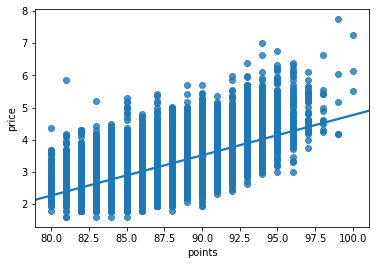

In [5]:
import seaborn as sns
import numpy as np

sns.regplot(df_wine.points, np.log(df_wine.price))

In [7]:
import torch
import numpy as np
import math

from torch import nn
from torch import optim
from torch.nn import functional as F

from sklearn.metrics import roc_auc_score, r2_score
import matplotlib.pyplot as plt

В качестве бейзлайна давайте воспользуемся хорошо известной библиотекой [statsmodels](https://www.statsmodels.org), где реализовано множество видов регрессионных моделей и много чего ещё. Пока никаких нейронных сетей, всё по классике.

In [6]:
import statsmodels.api as sm

model = sm.OLS(df_wine.points, sm.add_constant(np.log(df_wine.price))).fit()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Посмотрим, что получилось, наложив график предскзанных значений на график предсказанных и посчитав коэффициент детерминации $R^2$.

In [18]:
predicted = model.predict(sm.add_constant(np.log(df_wine.price)))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [21]:
r2 = r2_score(np.log(df_wine.price.values), predicted.values)
r2

-16262.368341642572

In [15]:
predicted

0        87.469388
1        94.860141
2        89.117707
3        86.196200
4        87.717750
           ...    
19994    87.053092
19995    85.531543
19996    89.782364
19997    87.053092
19999    88.719969
Length: 18198, dtype: float64

In [14]:
df_wine.price,

(0         23.0
 1        275.0
 2         40.0
 3         15.0
 4         25.0
          ...  
 19994     20.0
 19995     12.0
 19996     50.0
 19997     20.0
 19999     35.0
 Name: price, Length: 18198, dtype: float64,)

Text(0.5, 1.0, '$R^2$=-1.82')

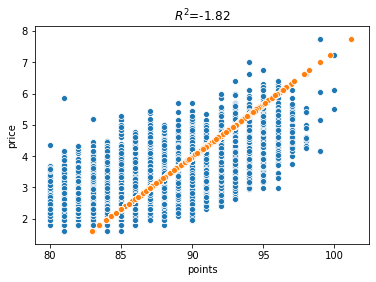

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


predicted = model.predict(sm.add_constant(np.log(df_wine.price)))
r2 = r2_score(df_wine.price, predicted)
sns.scatterplot(df_wine.points, np.log(df_wine.price))
sns.scatterplot(predicted, np.log(df_wine.price))

plt.title(f"$R^2$={r2:.2f}")

Выглядит неплохо.

In [785]:
y = df_wine.points.values.reshape(-1, 1)
X = np.log(df_wine.price.values).reshape(-1, 1)

In [786]:
y_tensor = torch.from_numpy(y).float()
X_tensor = torch.from_numpy(X).float()

In [787]:
X_train_tensor = X_tensor
y_train_tensor = y_tensor

In [791]:
learning_rate = 0.005
epochs = 10000

reg_model = nn.Linear(y_tensor.shape[1], X_tensor.shape[1])
criterion = nn.MSELoss() 
optimizer = optim.SGD(reg_model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient
    # from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    predictions = reg_model(X_train_tensor)

    # get loss for the predicted output
    loss = criterion(predictions, y_train_tensor)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 7491.40673828125
epoch 1000, loss 104.17947387695312
epoch 2000, loss 53.236854553222656
epoch 3000, loss 28.88201332092285
epoch 4000, loss 17.238420486450195
epoch 5000, loss 11.67186450958252
epoch 6000, loss 9.010592460632324
epoch 7000, loss 7.738311767578125
epoch 8000, loss 7.130056381225586
epoch 9000, loss 6.839260101318359


In [822]:
predicted = reg_model(X_train_tensor).data

In [825]:
r2_score(y_train_tensor.squeeze().numpy(), predicted.squeeze(1).numpy())

0.36024891732039865

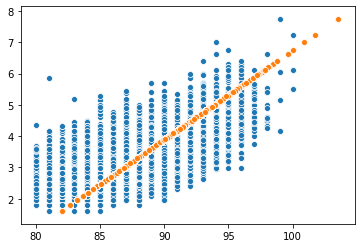

In [826]:
sns.scatterplot(y_train_tensor.squeeze(1).numpy(), X_train_tensor.squeeze(1).numpy())
sns.scatterplot(predicted.squeeze(1).numpy(), X_train_tensor.squeeze(1).numpy())

In [24]:
torch.nn.Linear??

Init signature: torch.nn.Linear(in_features, out_features, bias=True)
Source:        
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
          additional dimensions and :math:`H_{in} = \text{in\_features}`
        - Output: :math:`(N, *, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text

In [25]:
torch.functional.F.linear??

Signature: torch.functional.F.linear(input, weight, bias=None)
Source:   
def linear(input, weight, bias=None):
    # type: (Tensor, Tensor, Optional[Tensor]) -> Tensor
    r"""
    Applies a linear transformation to the incoming data: :math:`y = xA^T + b`.

    Shape:

        - Input: :math:`(N, *, in\_features)` where `*` means any number of
          additional dimensions
        - Weight: :math:`(out\_features, in\_features)`
        - Bias: :math:`(out\_features)`
        - Output: :math:`(N, *, out\_features)`
    """
    if input.dim() == 2 and bias is not None:
        # fused op is marginally faster
        ret = torch.addmm(bias, input, weight.t())
    else:
        output = input.matmul(weight.t())
        if bias is not None:
            output += bias
        ret = output
    return ret
File:      /usr/local/lib/python3.6/dist-packages/torch/nn/functional.py
Type:      function


Kaiming initialization [в оригинале](https://arxiv.org/pdf/1502.01852.pdf) или [попроще](https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138).

In [827]:
def lin_reg_model(X, w, b):
    return X @ w.t() + b

In [828]:
def mse(true, predicted):
    return ((true - predicted) ** 2).sum() / true.numel()

In [829]:
# по мотивами Kaiming initialization
w = torch.randn(y_tensor.shape[1], X_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[1])
b = torch.zeros(y_tensor.shape[1])

w.requires_grad_(True)
b.requires_grad_(True)

tensor([0.], requires_grad=True)

In [830]:
for i in range(epochs):
    predictions = lin_reg_model(X_train_tensor, w, b)
    loss = mse(predictions, y_train_tensor)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

In [831]:
predicted = lin_reg_model(X_train_tensor, w, b)

In [833]:
r2_score(y_train_tensor.squeeze().numpy(), predicted.squeeze().detach().numpy())

0.3601660455142316

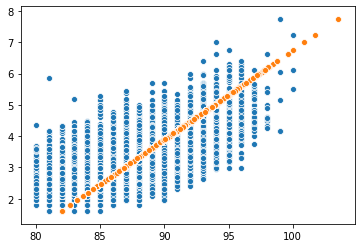

In [801]:
sns.scatterplot(y_train_tensor.squeeze(1).numpy(), X_train_tensor.squeeze(1).numpy())
sns.scatterplot(predicted.squeeze(1).detach().numpy(), X_train_tensor.squeeze(1).numpy())

# Классификатор

In [176]:
from sklearn.linear_model import LogisticRegression

In [221]:
y_bin_train_tensor = (y_train_tensor > y_train_tensor.median()).float()
y_bin_train = y_bin_train_tensor.numpy()

In [185]:
log_reg_sklearn = LogisticRegression(penalty="none")

In [187]:
log_reg_sklearn.fit(X, y_bin_train);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [190]:
predicted = log_reg_sklearn.predict(X)

In [191]:
roc_auc_score(y_bin_train, predicted)

0.7218437031912739

In [332]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [333]:
def log_reg_model(X, w, b):
    return sigmoid(X @ w.t() + b)

$$binary \ cross \ entropy= \frac{-1}{n} \sum_{n}y\cdot ln(\hat{y})+(1-y)\cdot ln(1-\hat{y})$$

In [334]:
# criterion = nn.CrossEntropyLoss()

def binary_cross_entropy(true, predicted):
    return -1 / len(true) * (true * predicted.log() + (1 - true) * (1 - predicted).log()).sum()

In [336]:
# по мотивами Kaiming initialization
w = torch.randn(y_tensor.shape[1], X_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[1])
b = torch.zeros(y_tensor.shape[1])

w.requires_grad_(True)
b.requires_grad_(True);

for i in range(100):
    predictions = log_reg_model(X_train_tensor, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_bin_train_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

In [339]:
predictions = log_reg_model(X_train_tensor, w, b)
roc_auc_score(y_bin_train, predictions.detach().numpy())

0.8127689987977705

## Регрессия с категориальными переменными

In [648]:
categorical_features = [
    "country",
    "region_1",
    "region_2",
    "variety",
    "winery",
    "province"
]
X_sparse = pd.get_dummies(
    df_wine[["price", "points"] + categorical_features],
    columns=categorical_features,
    drop_first=True,
    dummy_na=True
)
X_sparse.shape

(18198, 8440)

In [649]:
X_sparse_tensor = torch.from_numpy(X_sparse.values).float()

In [364]:
# по мотивами Kaiming initialization
w = torch.randn(y_tensor.shape[1], X_sparse_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[1])
b = torch.zeros(y_tensor.shape[1])

w.requires_grad_(True)
b.requires_grad_(True);

for i in range(100):
    predictions = log_reg_model(X_sparse_tensor, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_bin_train_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

In [365]:
predictions = log_reg_model(X_sparse_tensor, w, b)
roc_auc_score(y_bin_train, predictions.detach().numpy())

## Взаимодействие признаков

In [38]:
from sklearn.preprocessing import PolynomialFeatures

In [39]:
poly2 = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [40]:
interactions2 = poly2.fit_transform(X_sparse.loc[:, "country_Australia":].values)

MemoryError: Unable to allocate array with shape (18198, 35604141) and data type float64

## FM

$$\begin{split}\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= `\frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}\end{split}$$

$$\sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \textbf v_i, \textbf v_j \rangle x_i x_j = 
\frac{1}{2} \sum_{f=1}^{k} \Big( \big(\sum_{i=1}^{n} v_f^{(i)} x_i \big)^2 - \sum_{i=1}^{n}v_f^{(i) 2} x_i^2 \Big) = 
\frac{1}{2} \sum_{f=1}^{} \Big( S_{1,f}^2 - S_{2,f} \Big) =
\frac{1}{2} \Big( S_{1}^2 - S_{2} \Big),
$$

In [644]:
bin_features = X_sparse.columns[(X_sparse.nunique() == 2)]
X_sparse = X_sparse[bin_features]
X_sparse_tensor = torch.from_numpy(X_sparse.values).float()

In [647]:
bin_features.shape, X_sparse.shape

((8434,), (18198, 8434))

In [697]:
!ls /app

2weeks-granulation		 nohup.out
2weeks-granulation-chernobrovov  nuxt-pwp
adhoc				 polina
base-multilabel-clf		 recmetrics
blog				 rec-similar-dev
course-v3			 recsys-rubbles-2019
crm-sku				 test-brands-as-input
current-baseline-model		 tmp
dask-worker-space		 topic-modelling
deep-fm				 two-step-recsys-proxy
docs				 two-step-recsys-proxy-2weeks
get-data			 two-step-recsys-with-cats
job-interview			 two-step-recsys-with-resampling
jupyter_local.log		 two-step-xdeep-2month_cat
modules				 x5


In [741]:
train_df = pd.read_csv('/app/tmp/dota_train_binary_heroes.csv.zip', index_col='match_id_hash').astype(np.float32)
test_df = pd.read_csv('/app/tmp/dota_train_binary_heroes.csv.zip', index_col='match_id_hash').astype(np.float32)
target = pd.read_csv('/app/tmp/train_targets.csv.zip', index_col='match_id_hash')
y = target['radiant_win'].values.astype(np.float32)
y = y.reshape(-1,1)

In [742]:
train_df.shape, y.shape

((39675, 230), (39675, 1))

In [743]:
y_bin_train_tensor = torch.from_numpy(y)
X_sparse_tensor = torch.from_numpy(train_df.values)

In [763]:
def fm_model(X, V, w, b):
    s1 = ((X @ V) ** 2).sum(dim=1, keepdim=True)
    s2 = ((X ** 2) @ (V ** 2)).sum(dim=1, keepdim=True)
    interaction_term = (s1 - s2) / 2
    
    linear_term = lin_reg_model(X, w, b)
    return sigmoid(linear_term + interaction_term)

In [764]:
# по мотивами Kaiming initialization
w = torch.randn(y_bin_train_tensor.shape[1], X_sparse_tensor.shape[1]) / math.sqrt(2 / y_bin_train_tensor.shape[1])
b = torch.zeros(y_bin_train_tensor.shape[1])

k = 5
V = torch.randn(X_sparse_tensor.shape[1], k)

w.requires_grad_(True)
b.requires_grad_(True)
V.requires_grad_(True);

In [765]:
predictions = fm_model(torch.from_numpy(train_df.values), V, w, b)

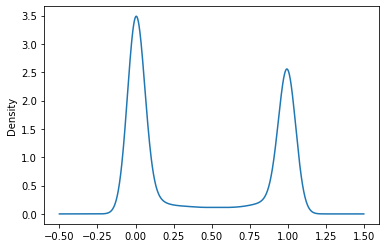

In [766]:
pd.Series(predictions.squeeze().detach().numpy()).plot(kind="kde")

In [767]:
binary_cross_entropy(predictions, sigmoid(y_bin_train_tensor))

tensor(0.7896, grad_fn=<MulBackward0>)

In [768]:
for i in range(100):
    predictions = fm_model(X_sparse_tensor, V, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_bin_train_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        V -= V.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()
        V.grad.zero_()
    if i % 20 == 0:
        print(i, loss)

0 tensor(0.7896, grad_fn=<MulBackward0>)
20 tensor(0.7895, grad_fn=<MulBackward0>)
40 tensor(0.7893, grad_fn=<MulBackward0>)
60 tensor(0.7892, grad_fn=<MulBackward0>)
80 tensor(0.7891, grad_fn=<MulBackward0>)


In [769]:
predictions = fm_model(X_sparse_tensor, V, w, b)

In [770]:
roc_auc_score(y_bin_train_tensor.squeeze().detach().numpy(), predictions.squeeze().detach().numpy())

0.5035172323360353

In [773]:
class TorchFM(nn.Module):
    def __init__(self, n=None, k=None):
        super().__init__()
        # Initially we fill V with random values sampled from Gaussian distribution
        # NB: use nn.Parameter to compute gradients
        self.V = nn.Parameter(torch.randn(n, k),requires_grad=True)
        self.lin = nn.Linear(n, 1)

        
    def forward(self, x):
        out_1 = torch.matmul(x, self.V).pow(2).sum(1, keepdim=True) #S_1^2
        out_2 = torch.matmul(x.pow(2), self.V.pow(2)).sum(1, keepdim=True) # S_2
        
        out_inter = 0.5*(out_1 - out_2)
        out_lin = self.lin(x)
        out = out_inter + out_lin
        
        return out

In [776]:
from torch import optim

learning_rate = 0.01
epochs = 1000
model = TorchFM(X_sparse_tensor.shape[1], 5)

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient
    # from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    predictions = model(X_sparse_tensor)

    # get loss for the predicted output
    loss = criterion(predictions, y_bin_train_tensor)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 5.944705963134766
epoch 100, loss 5.717885494232178
epoch 200, loss 5.506598472595215
epoch 300, loss 5.308901309967041
epoch 400, loss 5.123404026031494
epoch 500, loss 4.949056625366211
epoch 600, loss 4.785022735595703
epoch 700, loss 4.63062047958374
epoch 800, loss 4.48528528213501
epoch 900, loss 4.348516941070557


In [778]:
predictions = model(X_sparse_tensor)
roc_auc_score(y_bin_train_tensor.squeeze().detach().numpy(), predictions.squeeze().detach().numpy())

0.5009520269804396